In [30]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.io
from scipy import signal

import itertools
from statsmodels.tsa.arima_model import ARMA

In [2]:
mat = scipy.io.loadmat('PowerValuesOctMay.mat')
m = mat['MeasurementsTotal']

In [3]:
m = np.squeeze(m)

# Data Exploration

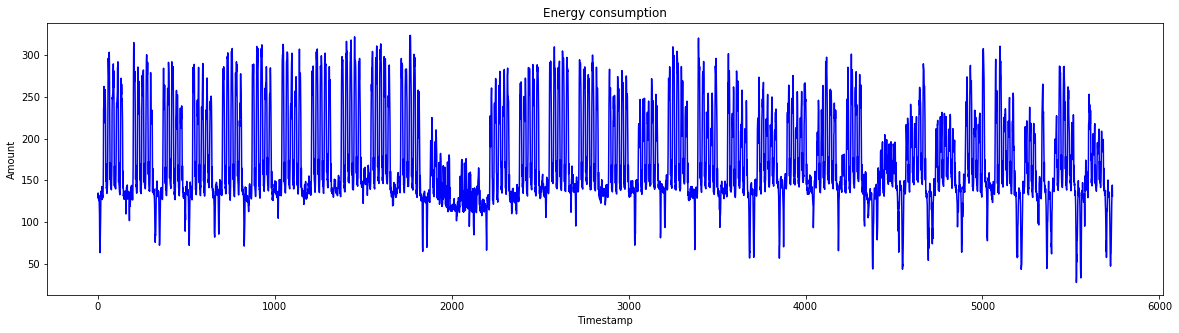

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))

ax.plot(m, c='b')
ax.set_title('Energy consumption')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Amount')
#plt.tight_layout()
#plt.savefig('data.png', dpi=300)
plt.show()

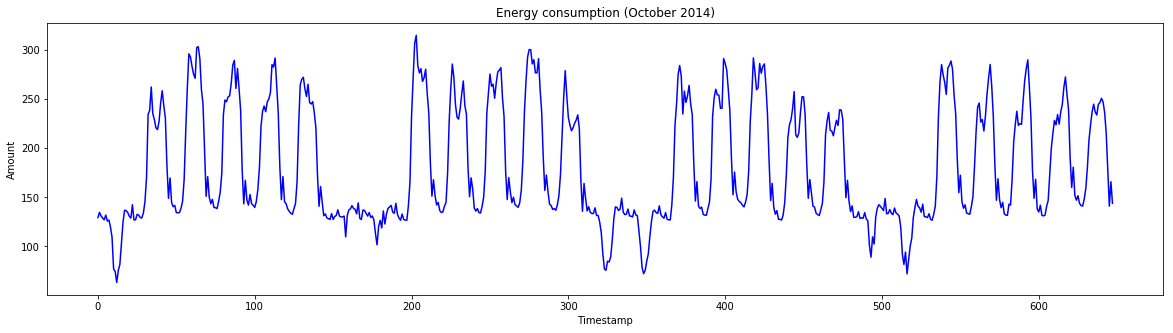

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))

ax.plot(m[:27*24], c='b')
ax.set_title('Energy consumption (October 2014)')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Amount')
#plt.tight_layout()
#plt.savefig('data.png', dpi=300)
plt.show()

/Users/Joel/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/Users/Joel/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


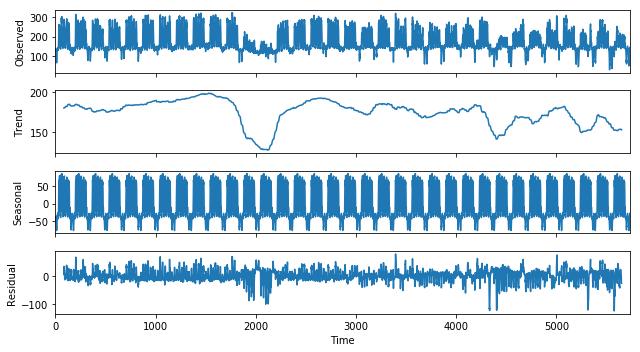

In [8]:
sd = seasonal_decompose(m, model='additive', freq=168)
sd.plot()
matplotlib.rcParams['figure.figsize'] = [9.0, 5.0]

/Users/Joel/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/Users/Joel/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


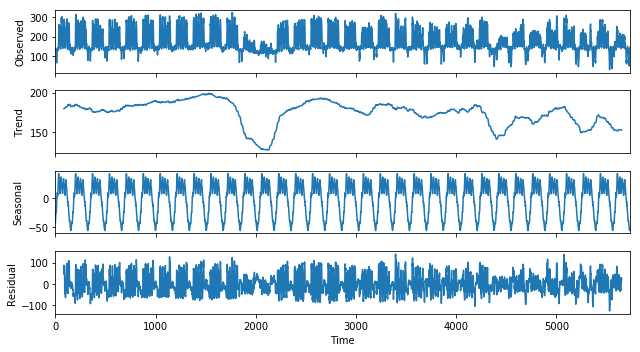

In [7]:
sd = seasonal_decompose(m, model='additive', freq=169)
sd.plot()
matplotlib.rcParams['figure.figsize'] = [9.0, 5.0]

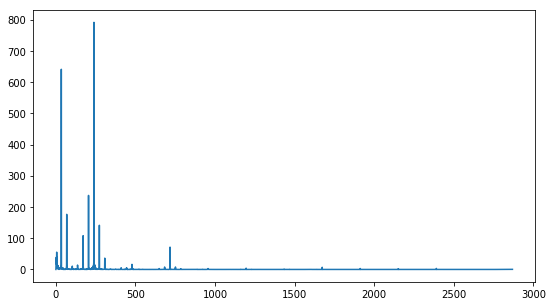

In [9]:
f, Pxx = signal.periodogram(m, scaling='spectrum')
plt.plot(Pxx)

In [10]:
tmp = Pxx.copy()
tmp.sort()
max_values = tmp[-2:]
max_freqs = [list(Pxx).index(v) for v in max_values]
print('Freq1: {:.0f} Freq2: {:.0f}'.format(1/max_freqs[1]*len(m), 1/max_freqs[0]*len(m)))

Freq1: 24 Freq2: 169


In [11]:
ratio_test = 0.1
num_samples = len(m)
index_split = int(num_samples*(1-ratio_test))
train = m[:index_split]
test = m[index_split:]
print('We have {} samples for training and {} samples for testing.'.format(len(train), len(test)))

We have 5162 samples for training and 574 samples for testing.


# Model fitting

[(1,), (24,), (168,), (1, 24), (1, 168), (24, 168), (1, 24, 168)]


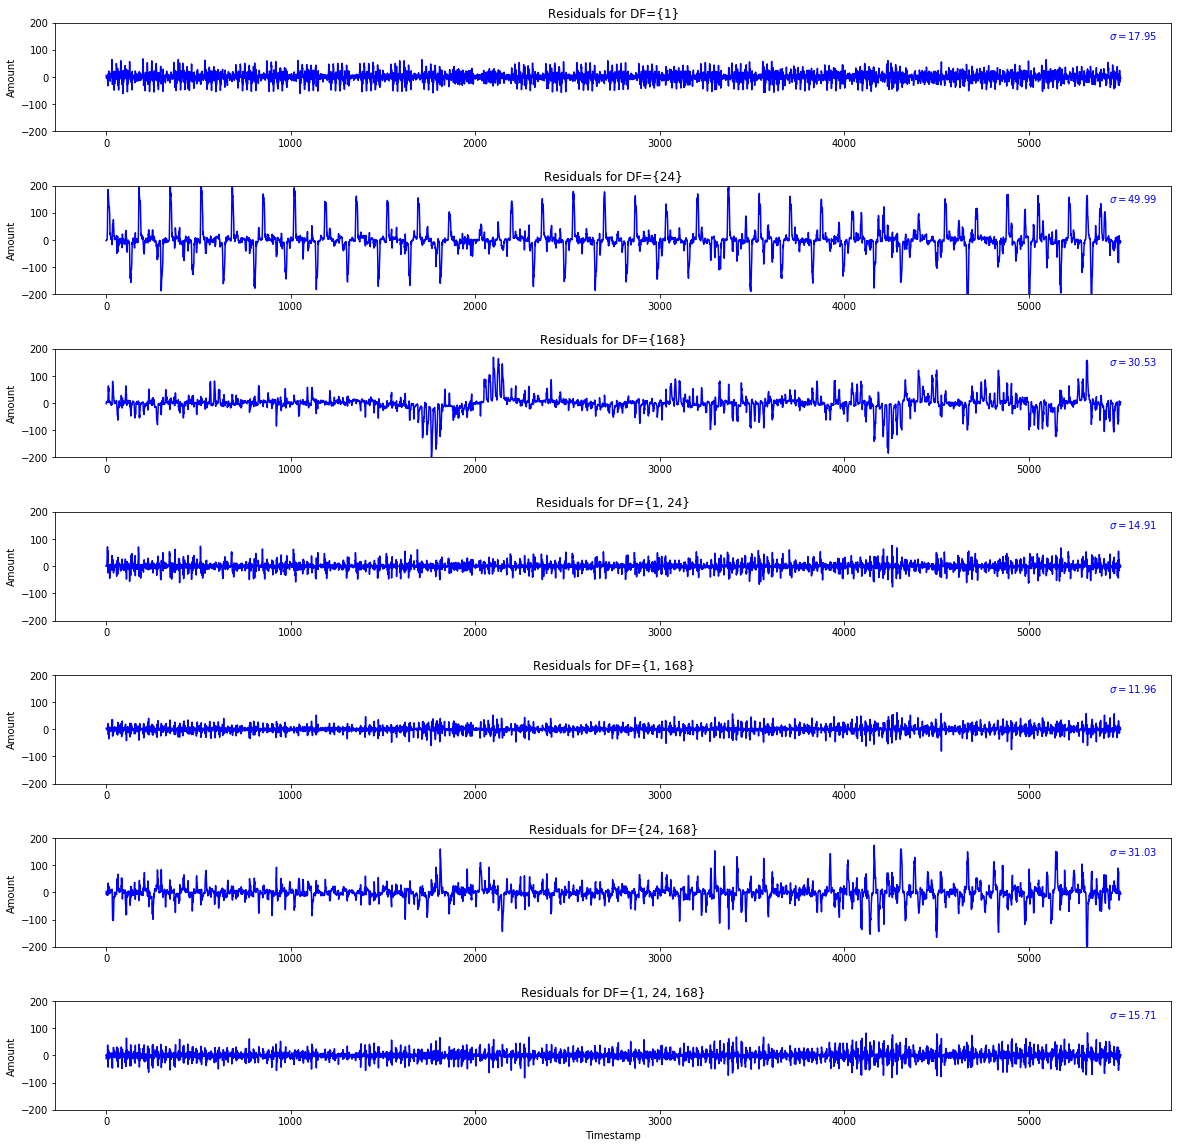

In [78]:
lags = [1, 24, 168]
combinations = []
for l in range(1,len(lags)+1):
    combinations.extend(list(itertools.combinations(lags, l)))
print(combinations)
m_diff = m
thres = 5500
fig, ax = plt.subplots(len(combinations), 1, figsize=(20,20))
plt.subplots_adjust(hspace = 0.5)
for i, lags in enumerate(combinations):
    
    m_diff = apply_differencing_filters(m, lags)[:thres]
    mean = np.mean(m_diff)
    std = np.std(m_diff)
    
    ax[i].text(5700, 130, r'$\sigma=${:.2f}'.format(std), ha='right', va='bottom', color='b')
    ax[i].plot(m_diff, c='b')
    ax[i].set_ylabel('Amount')
    ax[i].set_ylim([-200,200])
    if len(lags) == 1:
        ax[i].set_title('Residuals for DF={{{}}}'.format(str(lags)[1:-2]))
    else:
        ax[i].set_title('Residuals for DF={{{}}}'.format(str(lags)[1:-1]))
ax[-1].set_xlabel('Timestamp')
#plt.tight_layout()
#plt.savefig('data.png', dpi=300)
plt.show()

# Split data in train and test samples

In [47]:
def apply_differencing_filter(ts, lag):
    num_samples = len(ts)
    return ts[lag:num_samples] - ts[:num_samples-lag]
def apply_differencing_filters(ts, lags):
    for lag in lags:
        ts = apply_differencing_filter(ts, lag)
    return ts

### Assume differenced data is iid N(0, $\sigma^2$)

In [11]:
model = ARMA(m, order=(0, 1))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5736
Model:                     ARMA(0, 1)   Log Likelihood              -28085.454
Method:                       css-mle   S.D. of innovations             32.372
Date:                Fri, 05 Apr 2019   AIC                          56176.907
Time:                        15:29:20   BIC                          56196.871
Sample:                             0   HQIC                         56183.856
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        174.4303      0.800    217.977      0.000     172.862     175.999
ma.L1.y        0.8723      0.004    204.508      0.000       0.864       0.881
                                    Roots           

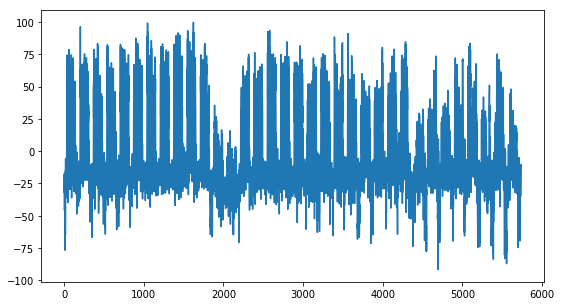

In [12]:
plt.plot(model_fit.resid)